In [1]:
%matplotlib inline
DEFAULT_FIGSIZE = (16, 12)

import gzip
import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

In [87]:
braking_df = pd.read_pickle('trial2_braking_ttc.p.gz')

# remove rows associated with rider 15
braking_df = braking_df.drop(
    braking_df[braking_df['rider id'] == 15].index)

# rename rider 16 to 15
braking_df.loc[braking_df['rider id'] == 16, 'rider id'] = 15

In [88]:
with pd.option_context('display.max_rows', 25,
                       'display.max_columns', None,
                       'float_format', '{:0.3f}'.format):
    display(braking_df)

,linregress slope,linregress intercept,linregress r-value,linregress p-value,linregress stderr,starting velocity,braking duration,braking distance,braking starttime,braking endtime,window size,lockup ranges,rider id,trial id,distance-to-collision,time-to-collision
0,-0.698,92.942,-0.967,0.000,0.008,3.694,4.401,8.091,128.370,132.770,55,0,0,0,7.815,2.115
1,-1.471,855.737,-0.997,0.000,0.006,4.713,3.296,8.010,578.273,581.570,55,0,0,1,8.705,1.847
2,-1.900,1257.373,-0.997,0.000,0.008,5.581,3.168,9.640,658.551,661.720,55,0,0,2,10.068,1.804
3,-1.717,1756.369,-0.994,0.000,0.010,4.524,2.864,7.395,1020.226,1023.090,55,0,0,6,7.788,1.722
4,-1.759,1944.489,-0.994,0.000,0.012,3.082,2.088,3.388,1103.388,1105.477,55,0,0,7,4.187,1.359
5,-2.140,2523.997,-0.996,0.000,0.009,5.799,3.072,9.353,1176.298,1179.370,55,0,0,8,9.950,1.716
6,-1.962,2990.284,-0.995,0.000,0.010,5.965,3.428,11.289,1520.923,1524.351,55,1,0,12,11.586,1.942
7,-1.589,2607.772,-0.995,0.000,0.011,2.877,1.656,2.942,1639.394,1641.050,55,0,0,13,3.300,1.147
8,-2.171,3731.208,-0.993,0.000,0.015,4.665,2.584,6.200,1716.346,1718.931,55,0,0,14,6.976,1.496
9,-0.799,422.680,-0.997,0.000,0.002,4.415,5.841,11.928,523.390,529.230,55,0,1,3,13.000,2.944


'#464646'

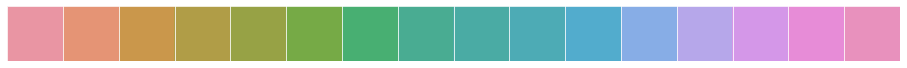

In [187]:
# categorical plots use a default saturation of 0.75
CATEGORICAL_PLOT_SATURATION = 0.75
helper = sns.categorical._CategoricalPlotter()
helper.hue_names = list(range(16))
helper.establish_colors(color=None, palette=None,
                        saturation=CATEGORICAL_PLOT_SATURATION)
sns.palplot(helper.colors)
helper.gray

In [280]:
def boxswarmplot(x, y, data, ax):
    # Don't plot outliers in boxplot as they will show up in the swarmplot.
    sns.boxplot(x=x, y=y, data=data,
                ax=ax, showfliers=False)
    
    # Set alpha transparency of the boxes (excluding edges).
    for patch in ax.artists:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.2))
    
    # Plot swarmplot in front of box face but behind median and IQR lines.
    # zorder for box is 0.9 while others are 2 or 2.1.
    sns.swarmplot(x=x, y=y, data=data,
                  ax=ax, zorder=1, alpha=1)

(numpy.record, [('slope', '<f8'), ('intercept', '<f8'), ('rvalue', '<f8'), ('pvalue', '<f8'), ('stderr', '<f8')])
pcc median:  0.931432935293
pcc range:  0.366201160204


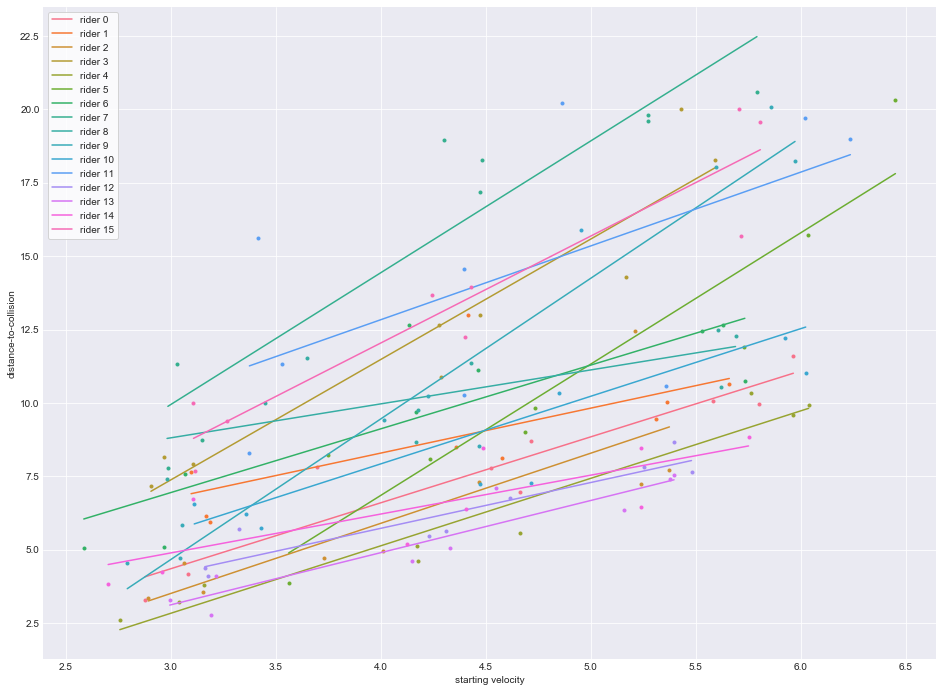

Text(0.5,0,'rider id')

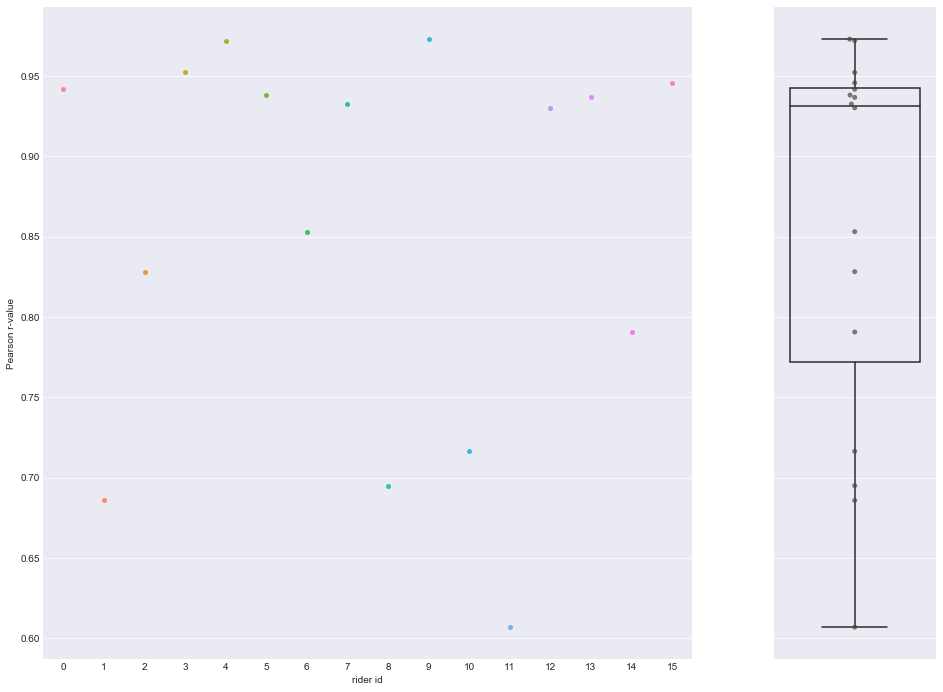

In [242]:
# results 1.1 - increase in speed results in larger braking distance
#
# Calculate pearson correlation coefficient for each person for distance-to-collision and starting velocity
# Range, median of PCC.

# How should we show this?
# Maybe we should calculate the linear regression, and then the error from the linear regression for each trial?

import scipy.stats

pcc = []
x = []
y = []
num_riders = 16
for i in range(num_riders):
    df = braking_df[braking_df['rider id'] == i]
    xi = df['starting velocity'].values
    yi = df['distance-to-collision'].values
    reg = scipy.stats.linregress(xi, yi)
    x.append(xi)
    y.append(yi)
    pcc.append(reg)
    
dtype = list(zip(pcc[0]._fields, len(pcc[0]._fields)*('float',)))
pcc = np.asarray(pcc, dtype=dtype).view(np.recarray)
print(pcc.dtype)
print('pcc median: ', np.median(pcc.rvalue))
print('pcc range: ', np.ptp(pcc.rvalue))

plt.close('all')
fig, ax = plt.subplots()

# Plot velocity vs. dtc for all trials and 
colors = sns.color_palette('husl', num_riders)
for i in range(num_riders):
    ax.plot(x[i], y[i], color=colors[i], linestyle=' ', marker='.')
    x_sorted = np.sort(x[i])
    ax.plot(x_sorted, pcc[i].slope*x_sorted + pcc[i].intercept,
            color=colors[i], label='rider {}'.format(i))
ax.set_xlabel('starting velocity')
ax.set_ylabel('distance-to-collision')
ax.legend()
plt.show()

fig2, ax2 = plt.subplots(1, 2,
                         gridspec_kw={'width_ratios': [4, 1]},
                         sharey=True)

sns.swarmplot(x=list(range(num_riders)), y=pcc.rvalue, ax=ax2[0])

sns.boxplot(pcc.rvalue, color=helper.gray, ax=ax2[1], 
            orient='v',
            boxprops={'facecolor': (0, 0, 0, 0)})
sns.swarmplot(x=pcc.rvalue, orient='v',
              color=helper.gray, ax=ax2[1],
              alpha=0.7)
    
ax2[0].set_ylabel('Pearson r-value')
ax2[0].set_xlabel('rider id')

(numpy.record, [('slope', '<f8'), ('intercept', '<f8'), ('rvalue', '<f8'), ('pvalue', '<f8'), ('stderr', '<f8')])
pcc median:  0.931432935293
pcc range:  0.366201160204
Pearson correlation coefficient table


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
slope,2.246774,1.531933,2.389854,4.103385,2.299145,4.473979,2.172291,4.490928,1.156980,4.792374,2.303861,2.514621,1.560870,1.777634,1.324952,3.643813
intercept,-2.390966,2.161814,-3.662683,-4.935937,-4.065891,-11.048589,0.426769,-3.530376,5.338575,-9.716519,-1.293544,2.774654,-0.517199,-2.213206,0.913343,-2.536004
rvalue,0.941819,0.685747,0.828221,0.952290,0.972079,0.938188,0.853133,0.932628,0.694939,0.973025,0.716317,0.606823,0.930237,0.936753,0.790619,0.945785
pvalue,0.000148,0.041430,0.005822,0.000075,0.000012,0.000563,0.003452,0.000245,0.037718,0.000010,0.029936,0.083141,0.000276,0.000197,0.011193,0.000116
stderr,0.303066,0.614558,0.611188,0.497053,0.209771,0.673851,0.502075,0.656736,0.452481,0.429465,0.848239,1.244913,0.232724,0.251029,0.387842,0.472955


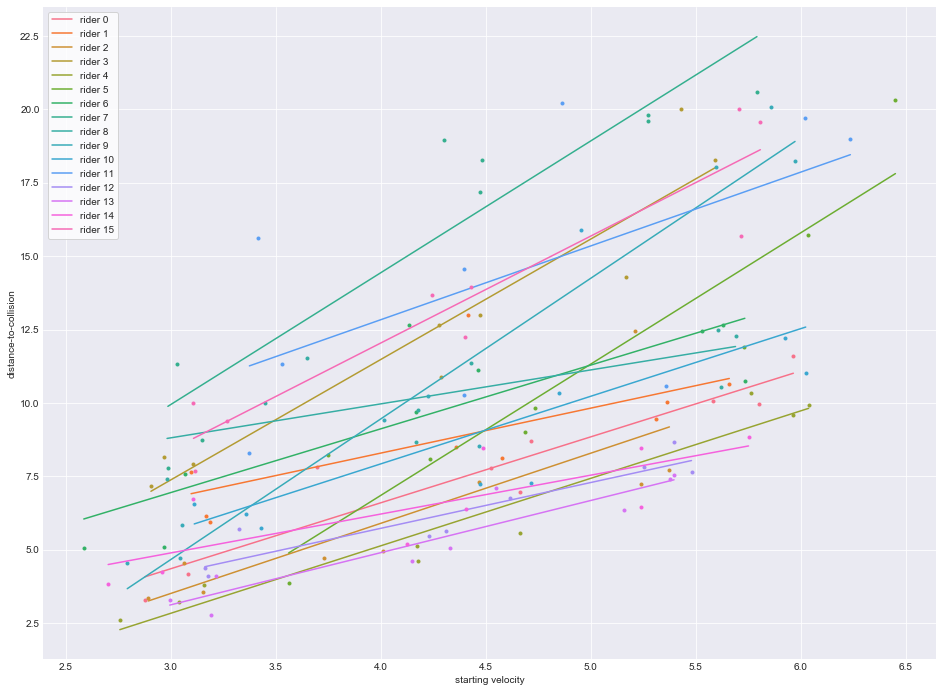

Text(0.5,0,'rider id')

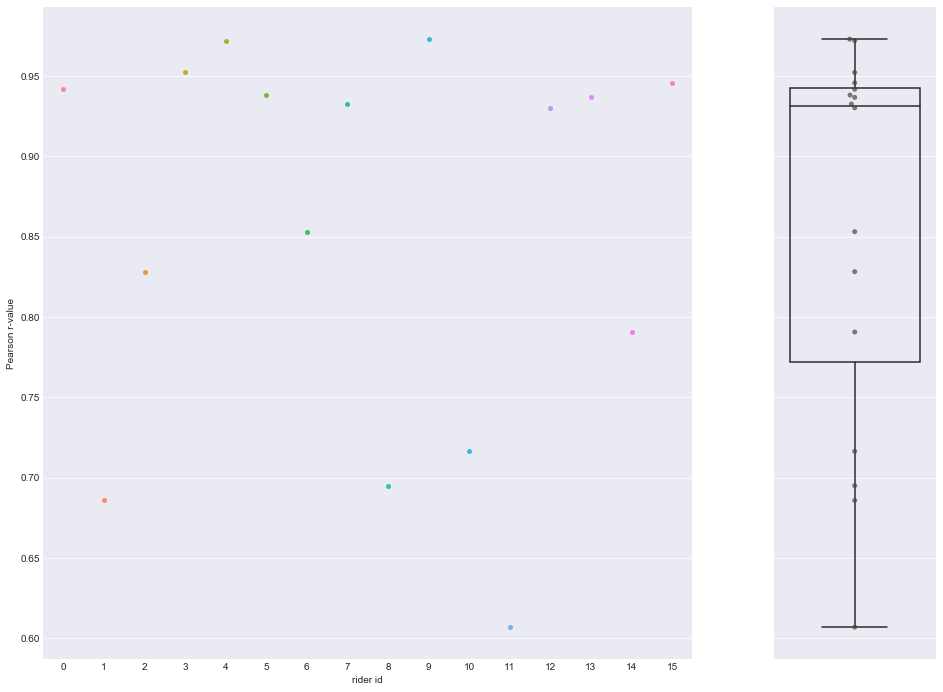

In [243]:
# results 1.1 - increase in speed results in larger braking distance
#
# Calculate pearson correlation coefficient for each person for distance-to-collision and starting velocity
# Range, median of PCC.

# How should we show this?
# Maybe we should calculate the linear regression, and then the error from the linear regression for each trial?

import scipy.stats

# Calculate Pearson correlation coefficient for each rider
pcc = []
x = []
y = []
num_riders = 16
for i in range(num_riders):
    df = braking_df[braking_df['rider id'] == i]
    xi = df['starting velocity'].values
    yi = df['distance-to-collision'].values
    reg = scipy.stats.linregress(xi, yi)
    x.append(xi)
    y.append(yi)
    pcc.append(reg)
    
# create PCC dataframe
dtype = list(zip(pcc[0]._fields, len(pcc[0]._fields)*('float',)))
pcc = np.asarray(pcc, dtype=dtype).view(np.recarray)
print(pcc.dtype)
print('pcc median: ', np.median(pcc.rvalue))
print('pcc range: ', np.ptp(pcc.rvalue))
pcc_df = pd.DataFrame(data=pcc).transpose()
print('Pearson correlation coefficient table')
display(pcc_df)

plt.close('all')
fig, ax = plt.subplots()

# Plot velocity vs. dtc for all trials
colors = sns.color_palette('husl', num_riders)
for i in range(num_riders):
    ax.plot(x[i], y[i], color=colors[i], linestyle=' ', marker='.')
    x_sorted = np.sort(x[i])
    ax.plot(x_sorted, pcc[i].slope*x_sorted + pcc[i].intercept,
            color=colors[i], label='rider {}'.format(i))
ax.set_xlabel('starting velocity')
ax.set_ylabel('distance-to-collision')
ax.legend()
plt.show()

fig2, ax2 = plt.subplots(1, 2,
                         gridspec_kw={'width_ratios': [4, 1]},
                         sharey=True)

sns.swarmplot(x=list(range(num_riders)), y=pcc.rvalue, ax=ax2[0])

sns.boxplot(pcc.rvalue, color=helper.gray, ax=ax2[1], 
            orient='v',
            boxprops={'facecolor': (0, 0, 0, 0)})
sns.swarmplot(x=pcc.rvalue, orient='v',
              color=helper.gray, ax=ax2[1],
              alpha=0.7)
    
ax2[0].set_ylabel('Pearson r-value')
ax2[0].set_xlabel('rider id')

# Calculate residuals for each rider

PCC residual table (per rider)


,0,1,2,3,4,5,6,7,8,9,...,133,134,135,136,137,138,139,140,141,142
linregress residual,-0.774412,-0.345737,1.904900,0.014951,-1.113502,0.506417,-0.080228,-0.687502,0.575115,0.725164,...,0.309851,1.202729,-1.148525,-0.000293,0.761983,-1.247694,0.343834,1.754792,-2.596297,0.929472
rider id,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,14.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
starting velocity,2.877462,3.081553,3.694465,4.523917,4.664880,4.713384,5.580908,5.798840,5.964732,3.097177,...,5.751383,3.108715,3.117717,3.267400,4.244716,4.400665,4.431446,5.706208,5.714244,5.807667


/Users/oliver/miniconda3/envs/dev/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


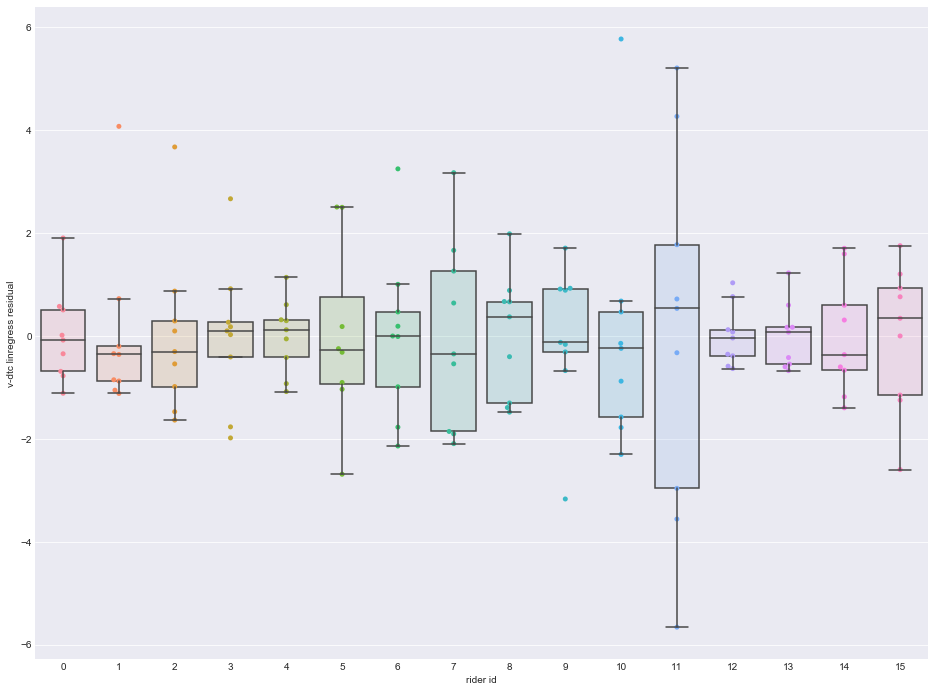

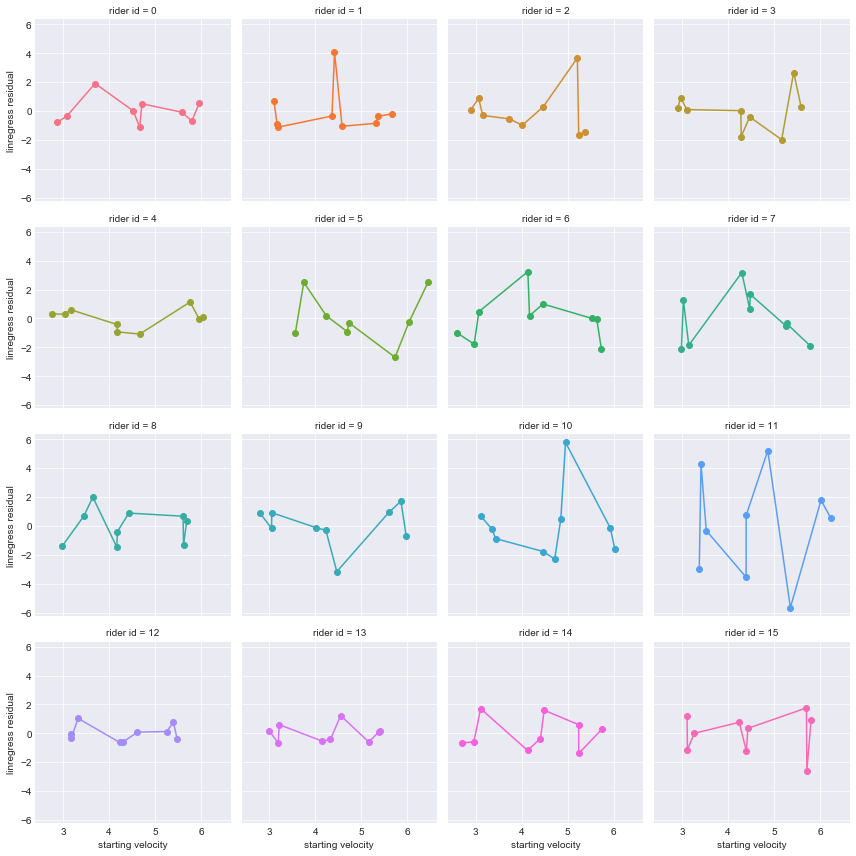

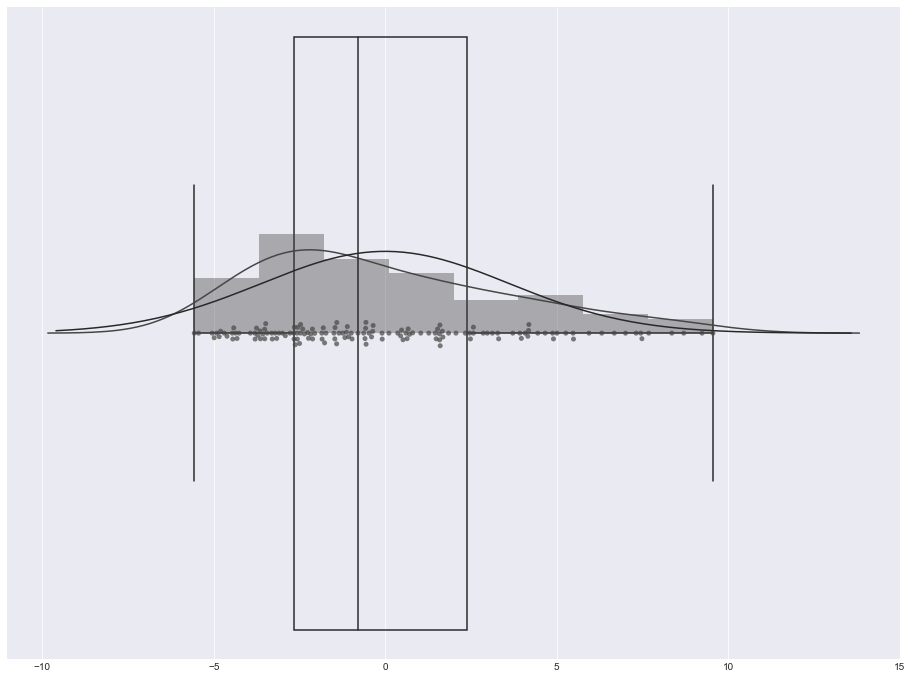

In [299]:
def calculate_linregress_residuals(data, x, y):
    x_ = data[x].values
    y_ = data[y].values
    
    reg = scipy.stats.linregress(x_, y_)
    #print(reg)
    
    sorted_index = np.argsort(x_)
    sorted_x = x_[sorted_index]
    
    observed_y = y_[sorted_index]
    predicted_y = reg.slope*sorted_x + reg.intercept
    
    residual = observed_y - predicted_y
    # print normalized residual error
    #print(np.sqrt(np.sum(residual**2))/len(residual))
    return sorted_x, residual


d = {
    'rider id': [],
    'starting velocity': [],
    'linregress residual': [],
}
for i in range(num_riders):
    sorted_velocity, residual = calculate_linregress_residuals(
        braking_df[braking_df['rider id'] == i],
        'starting velocity',
        'distance-to-collision')
    
    d['rider id'].extend(len(residual)*[i])
    d['starting velocity'].extend(sorted_velocity)
    d['linregress residual'].extend(residual)

pcc_residual_df = pd.DataFrame(data=d)
print('PCC residual table (per rider)')
display(pcc_residual_df.transpose())

fig, ax = plt.subplots()
boxswarmplot(x='rider id', y='linregress residual',
             data=pcc_residual_df,
             ax=ax)
ax.set_ylabel('v-dtc linregress residual')

# plot velocity vs. residuals for each rider
grid = sns.FacetGrid(pcc_residual_df, col='rider id', hue='rider id',
                     col_wrap=4)
grid.map(plt.plot, 'starting velocity', 'linregress residual', marker='o')

# plot boxswarm of all data
velocity_all, residual_all = calculate_linregress_residuals(
    braking_df, 'starting velocity', 'distance-to-collision')

fig, ax = plt.subplots()
sns.boxplot(residual_all,
            color=helper.gray, ax=ax, 
            #orient='v',
            boxprops={'facecolor': (0, 0, 0, 0)})
sns.swarmplot(residual_all,
              color=helper.gray, ax=ax,
              alpha=0.7)
sns.distplot(residual_all,
             color=helper.gray, ax=ax,
             fit=scipy.stats.norm)
ax.autoscale(axis='y')

braking deceleration table


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
linregress intercept,0.789803,-0.791514,2.182335,0.548833,1.780558,1.283708,0.097014,0.136237,0.007897,1.000685,0.536691,-0.062473,1.482130,1.684636,-0.120572,0.462993
linregress pvalue,0.154345,0.010887,0.863880,0.141483,0.047104,0.857821,0.005204,0.017044,0.008089,0.622357,0.107406,0.059195,0.161449,0.134291,0.002567,0.022060
linregress rvalue,0.516715,0.792379,0.067069,0.530789,0.672670,0.076122,0.833924,0.761827,0.810292,0.191095,0.572194,0.647840,0.509233,0.538987,0.865544,0.742062
linregress slope,0.202898,0.532589,0.024180,0.066062,0.114260,0.014637,0.262710,0.130510,0.362463,0.032020,0.225520,0.256330,0.093375,0.177521,0.484909,0.102344
linregress stderr,0.127067,0.154975,0.135957,0.039868,0.047505,0.078272,0.065712,0.041944,0.099081,0.062165,0.122171,0.113923,0.059646,0.104857,0.106051,0.034943
median,1.759153,1.571708,2.338976,0.781034,2.308894,1.353796,1.102937,0.649080,1.468987,1.163118,1.459233,1.048774,1.860944,2.428944,1.954746,0.876229
std,0.421086,0.635409,0.336834,0.123319,0.205880,0.192473,0.357949,0.169813,0.426712,0.196781,0.396141,0.406121,0.162972,0.296233,0.580757,0.145598


overall
median:  1.46898666065
std:  0.627442357804


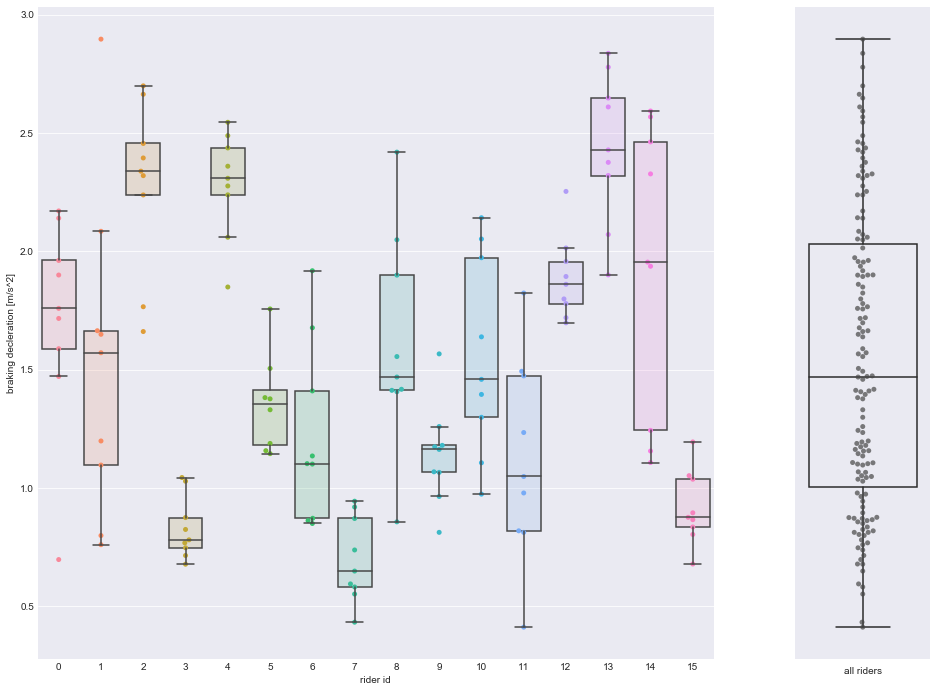

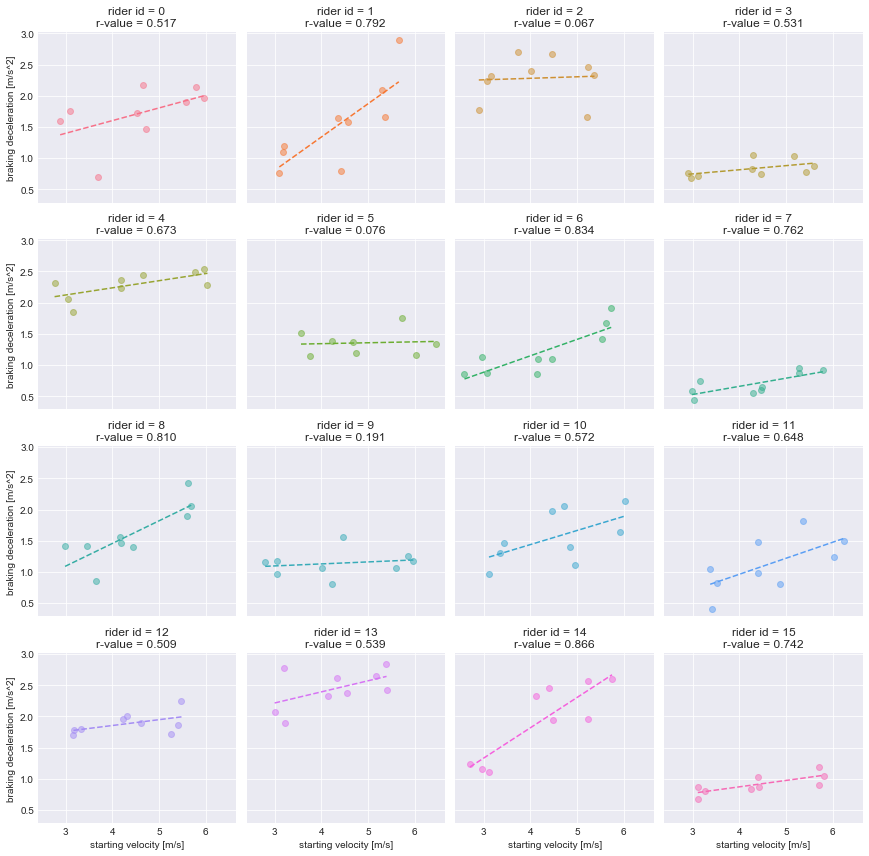

In [342]:
# results 1.2 - increase in speed results in earlier braking
#
# Braking decleration is independent from speed.

# Add deceleration column
f = lambda row: -row['linregress slope']
braking_df['deceleration'] = braking_df.apply(f, axis=1)

num_riders = 16
d = {'median': [], 'std': []}
for i in range(num_riders):
    df = braking_df[braking_df['rider id'] == i]
    v = df['deceleration'].values
    d['median'].append(np.median(v))
    d['std'].append(np.std(v))
    
    # print PCC for velocity-deceleration
    reg = scipy.stats.linregress(
        df['starting velocity'], v)
    for k in reg._fields:
        dictkey = 'linregress ' + k
        dictvalue = getattr(reg, k)
        if dictkey in d:
            d[dictkey].append(dictvalue)
        else:
            d[dictkey] = [dictvalue]
    
deceleration_df = pd.DataFrame(data=d).transpose()
print('braking deceleration table')
display(deceleration_df)

print('overall')
v = braking_df['deceleration'].values
print('median: ', np.median(v))
print('std: ', np.std(v))
    
fig, ax = plt.subplots(1, 2, sharey=True,
                       gridspec_kw={'width_ratios': [5, 1]})
                       
plot_swarm_overlay = True
                       
if not plot_swarm_overlay:
    # get a ligher gray for the box face color
    c = sns.light_palette(helper.gray)[3]
    sns.boxplot(x='deceleration', data=braking_df,
                color=helper.gray, ax=ax[1], 
                orient='v',
                boxprops={'facecolor': c})
else:
    sns.boxplot(x='deceleration', data=braking_df,
                color=helper.gray, ax=ax[1], 
                orient='v',
                boxprops={'facecolor': (0, 0, 0, 0)})
    sns.swarmplot(y='deceleration', data=braking_df,
                  color=helper.gray, ax=ax[1],
                  alpha=0.7)
    #sns.distplot(braking_df['deceleration'].values,
    #             color=helper.gray, ax=ax[1],
    #             fit=scipy.stats.norm,
    #             vertical=True)
    #ax[1].autoscale(axis='x')

if not plot_swarm_overlay:
    sns.boxplot(x='rider id', y='deceleration',
                data=braking_df,
                ax=ax[0])
else:
    boxswarmplot(x='rider id', y='deceleration',
                 data=braking_df,
                 ax=ax[0])
ax[0].set_ylabel('braking decleration [m/s^2]')
ax[1].get_yaxis().set_visible(False)
ax[0].set_xlabel('rider id')
ax[1].set_xlabel('all riders')

# plot velocity vs. deceleration for each rider
grid = sns.FacetGrid(braking_df, col='rider id', hue='rider id',
                     col_wrap=4)

# plot deceleration for each trial
grid.map(plt.plot, 'starting velocity', 'deceleration',
         marker='o', linestyle=' ', alpha=0.5)

# plot deceleration linear regression
## we need a function that takes the 'starting velocity' dataframe column,
## sorts it, and then accesses the deceleration linear regression in order
## to plot the linefit
def sorted_plot(x, *args, **kwargs):
    i = int(kwargs['label'])
    sorted_x = np.sort(x.values)
    slope = deceleration_df[i]['linregress slope']
    intercept = deceleration_df[i]['linregress intercept']
    return plt.plot(sorted_x, slope*sorted_x + intercept, *args, **kwargs)

grid.map(sorted_plot, 'starting velocity',
         linestyle='--')

# add text with r-value to each facet
for i, axis in enumerate(grid.axes.flat):
    r = deceleration_df[i]['linregress rvalue']
    axis.set_title(axis.get_title() + '\nr-value = {:0.3f}'.format(r))
    
grid.fig.tight_layout()
grid.set_xlabels('starting velocity [m/s]')
grid.set_ylabels('braking deceleration [m/s^2]')

In [ ]:
# 1.3 - linear model for velocity of profile when braking
